# Gompertz Model

In this notebook we will explore the application of optimization modeling to study this problem and gain insight on possible therapuetic strategies.





## Installing Pyomo and solvers

### Installation

The [IDAES Project](https://idaes-pse.readthedocs.io/en/latest/tutorials/getting_started/index.html) maintains a version of Pyomo and associated solvers. The following cells will install Pyomo and selected solvers from the IDAES project.

In [1]:
import sys

# install pyomo and solvers for Google Colab
if "google.colab" in sys.modules:
    !pip install -q idaes-pse >/dev/null 2>/dev/null
    !idaes get-extensions
    import idaes

Getting files...
Done
---------------------------------------------------
IDAES Extensions Build Versions
Solvers:  v3.2.0 20230203-1503 ubuntu2004-x86_64
Library:  v3.2.0 20230203-1528 ubuntu2004-x86_64


### Importing Pyomo and solvers

The following solvers are included in the IDAES distribution. 

| Solver | Description | linear | binary/integer | nonlinear |
| :-- | :-- | :--: | :--: | :--: |
| clp | linear programming | &#10003; | | 
| cbc | mixed integer linear programming | &#10003; | &#10003; | 
| ipopt | nonlinear programming | &#10003; | | &#10003;
| bonmin | mixed integer nonlinear programming | &#10003; | &#10003; | &#10003;
| couenne | global mixed integer nonlinear programming | &#10003; | &#10003; | &#10003;


In [2]:
import pyomo.environ as pyo
import pyomo.dae as dae

import matplotlib.pyplot as plt
import numpy as np

# transformer to convert DAEs to systems of nonlinear equations
transformer = pyo.TransformationFactory('dae.finite_difference')

# solver
solver = pyo.SolverFactory('ipopt')
solver.options['tol'] = 1e-12

## Simulating Tumor Growth

The well-known Gompertz model for tumor growth is given by

$$
\begin{align}
\frac{dN}{dt} & = -r N \log\left(\frac{N}{K}\right) & \text{Gompertz model} \\
N(0) & = N_0 & \text{initial condition} \\
\end{align}
$$

where $N$ is proportional to tumor volume, where $K$ is the carrying capacity of the tumor and $r$ is an intrinsic growth rate.  As long as $N < K$ the tumor will continue to grow. $K$ depends on the vascularization in the tumor and surrounding regions, and the available nutrients.

| Parameter | Value | Units |
| :---: | :---: | :--- |
| $N_0$ | 1 | mm$^3$ |
| $K$ | 30 | mm$^3$ |
| $r$ | 0.006 | 1/day |

Given the parameter values above, prepare a simulation of tumor growth over a two year (i.e., 730 day) period period using Pyomo and [Pyomo.DAE](https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html#). Create a plot for $N(t)$ as function of $t$.





In [3]:
# parameter values
r = 0.006
K = 30
N0 = 1.0

# time horizon
tf = 730

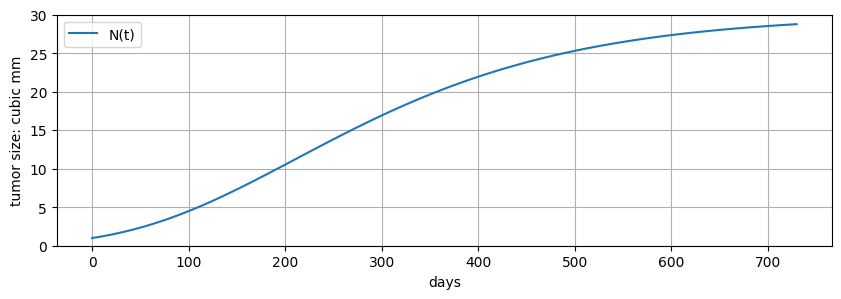

In [4]:
# build model
m = pyo.ConcreteModel()

# dependent variables: t
m.t = dae.ContinuousSet(bounds=(0, tf))

# indepedent variables: N and dN/dt
m.N = pyo.Var(m.t, bounds=(0, None), initialize=N0)
m.dN = dae.DerivativeVar(m.N, wrt=m.t)

# we need to use Pyomo's log function
@m.Constraint(m.t)
def ode(m, t):
    return m.dN[t] == - r * m.N[t] * pyo.log(m.N[t]/K) 

# initial condition
m.N[0].fix(N0)

# transform and solve
transformer.apply_to(m, wrt=m.t, nfe=120, scheme="FORWARD")
solver.solve(m)

# plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(m.t, [m.N[t].value for t in m.t], label="N(t)")
ax.set_xlabel("days")
ax.set_ylabel("tumor size: cubic mm")
ax.set_ylim(0, K)
ax.legend()
ax.grid(True)

## Controlling Tumor Growth

Cancer therapy can take different forms, including chemotheraphy and radiation therapy. The effect of therapy is modeled as

$$
\begin{align}
\frac{dN}{dt} & = -r N \log\left(\frac{N}{K}\right) + \alpha N u(t) && \text{Gompertz model w/therapy} \\
N(0) & = N_0 && \text{initial condition} \\
\end{align}
$$

where $u(t)$ is the daily amount of therapy applied, and $\alpha$ is a therapy dependent constant. For the purposes of this notebook, the following paramater values are used for all simulations.

| Parameter | Value | Units |
| :---: | :---: | :--- |
| $\alpha$ | 0.01 | 1/[U] |

For an initial exploration, assume $u(t)$ is constant. Simulate the response of the tumor to increasing levels of $u$. 

In [7]:
# parameter

alpha = 0.01

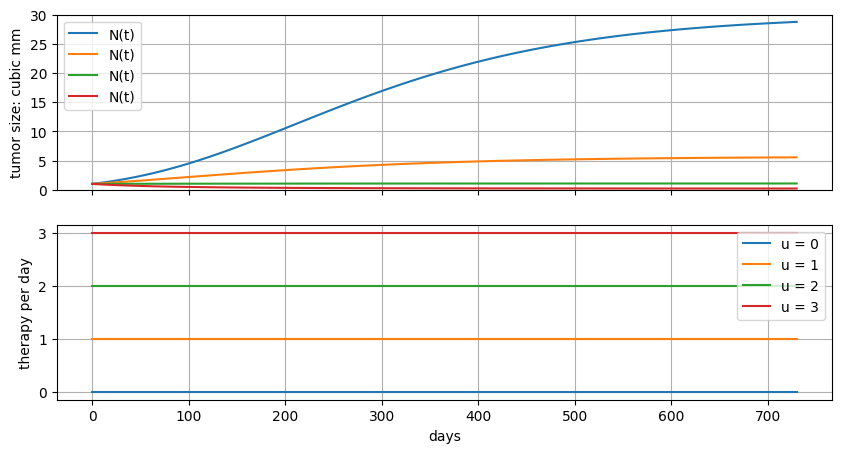

In [8]:
def gompertz(ax, u):

    # build model
    m = pyo.ConcreteModel()

    # dependent variables -> t
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # indepedent variables -> N and dN/dt
    m.N = pyo.Var(m.t, bounds=(0, None), initialize=N0)
    m.dN = dae.DerivativeVar(m.N, wrt=m.t)

    # we need to use Pyomo's log function
    @m.Constraint(m.t)
    def ode(m, t):
        return m.dN[t] == - r * m.N[t] * pyo.log( m.N[t]/K) - alpha * m.N[t] * u

    # initial condition
    m.N[0].fix(N0)

    # transform and solve
    transformer.apply_to(m, wrt=m.t, nfe=120, scheme="FORWARD")
    solver.solve(m)

    # plot results
    ax[0].plot(m.t, [m.N[t].value for t in m.t], label="N(t)")
    ax[0].set_ylabel("tumor size: cubic mm")
    ax[0].set_ylim(0, K)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(m.t, [u] * len(m.t), label=f"u = {u}")
    ax[1].set_xlabel("days")
    ax[1].set_ylabel("therapy per day")
    ax[1].legend()
    ax[1].grid(True)


fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
gompertz(ax, 0)
gompertz(ax, 1)
gompertz(ax, 2)
gompertz(ax, 3)

## Optimal Control: Constant $u$


Let's design a constant rate of therapy to target a desired outcome $N_f$.

$$N(t_f) = N_f$$

The model becomes 

$$
\begin{align}
\frac{dN}{dt} & = -r N \log\left(\frac{N}{K}\right) - \alpha N(t) \bar{u} && \text{Gompertz model}\\
N(0) & = N_0 && \text{initial condition}\\
N(t_f) & = N_f && \text{final condition} \\
\end{align}
$$

and $\bar{u}$ is a unknown constant, and therefore a decision variable for the solver.


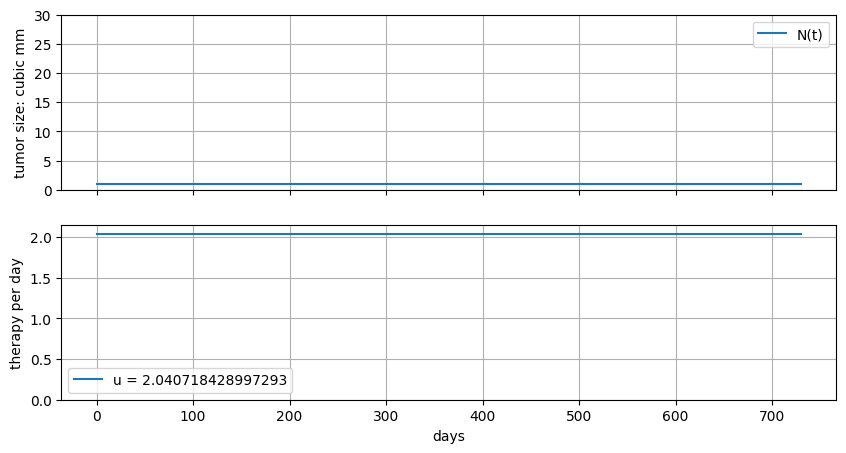

In [9]:
def gompertz(ax):

    # build model
    m = pyo.ConcreteModel()

    # dependent variables -> t
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # indepedent variables -> N and dN/dt
    m.N = pyo.Var(m.t, bounds=(0, None), initialize=N0)
    m.dN = dae.DerivativeVar(m.N, wrt=m.t)

    # control variable
    m.u = pyo.Var(bounds=(0, None))

    # we need to use Pyomo's log function
    @m.Constraint(m.t)
    def ode(m, t):
        return m.dN[t] == - r * m.N[t] * pyo.log( m.N[t]/K) - alpha * m.N[t] * m.u

    # initial condition
    m.N[0].fix(N0)
    m.N[tf].fix(N0)

    # transform and solve
    transformer.apply_to(m, wrt=m.t, nfe=120, scheme="FORWARD")
    solver.solve(m)

    # plot results
    ax[0].plot(m.t, [m.N[t].value for t in m.t], label="N(t)")
    ax[0].set_ylabel("tumor size: cubic mm")
    ax[0].set_ylim(0, K)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(m.t, [m.u.value for t in m.t], label=f"u = {m.u.value}")
    ax[1].set_ylim(0, None)
    ax[1].set_xlabel("days")
    ax[1].set_ylabel("therapy per day")
    ax[1].legend()
    ax[1].grid(True)


fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
gompertz(ax)

## Time-varying $u(t)$

What happens if we make $u(t)$ time varying? The model becomes 

$$
\begin{align}
\frac{dN}{dt} & = -r N \log\left(\frac{N}{K}\right) - \alpha N(t) u(t) && \text{Gompertz model}\\
N(0) & = N_0 && \text{initial condition}\\
N(t_f) & = N_f && \text{final condition} \\
\end{align}
$$

This is underdetermined. As long as the initial and final conditions are satisfied, any $u(t)$ will do. Don't be surprised if the solver reports a something crazy.

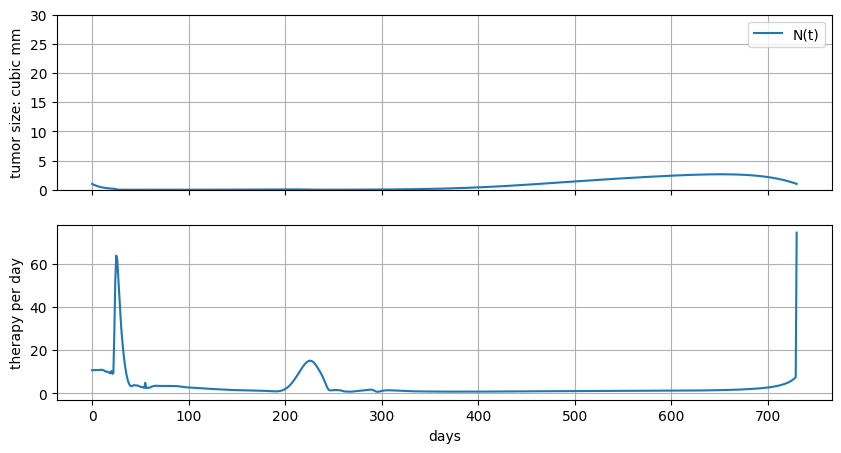

In [11]:
def gompertz(ax):

    # build model
    m = pyo.ConcreteModel()

    # dependent variables -> t
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # indepedent variables -> N and dN/dt
    m.N = pyo.Var(m.t, bounds=(0, None), initialize=N0)
    m.dN = dae.DerivativeVar(m.N, wrt=m.t)
    m.u = pyo.Var(m.t, bounds=(0, None))

    # we need to use Pyomo's log function
    @m.Constraint(m.t)
    def ode(m, t):
        return m.dN[t] == - r * m.N[t] * pyo.log( m.N[t]/K) - alpha * m.N[t] * m.u[t]

    # initial condition
    m.N[0].fix(N0)
    m.N[tf].fix(N0)

    # transform and solve
    transformer.apply_to(m, wrt=m.t, nfe=730, scheme="FORWARD")
    solver.solve(m)

    # plot results
    ax[0].plot(m.t, [m.N[t].value for t in m.t], label="N(t)")
    ax[0].set_ylabel("tumor size: cubic mm")
    ax[0].set_ylim(0, K)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(m.t, [m.u[t].value for t in m.t])
    ax[1].set_xlabel("days")
    ax[1].set_ylabel("therapy per day")
    ax[1].grid(True)


fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
gompertz(ax)

## Measuring total dosage

Let's try to minimize total dosage.

$$u_{total} = \int_0^{t_f} u(t)\ dt$$


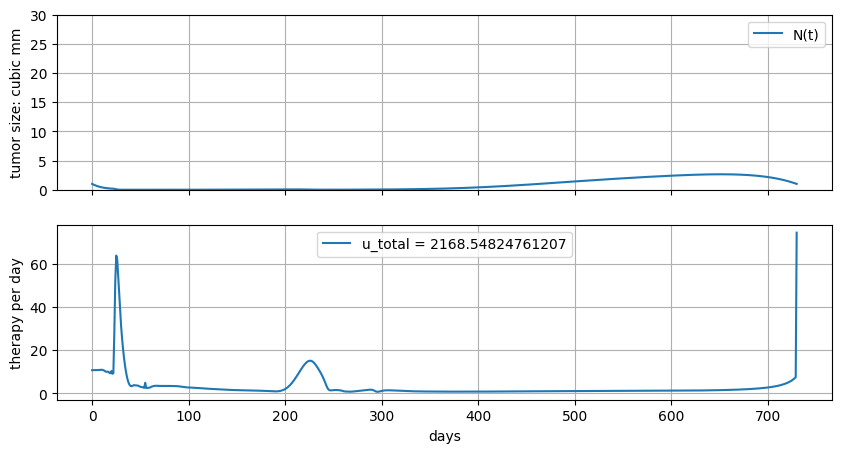

In [10]:
def gompertz(ax):

    # build model
    m = pyo.ConcreteModel()

    # dependent variables -> t
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # indepedent variables -> N and dN/dt
    m.N = pyo.Var(m.t, bounds=(0, None), initialize=N0)
    m.dN = dae.DerivativeVar(m.N, wrt=m.t)
    m.u = pyo.Var(m.t, bounds=(0, None))

    # measuring total amount
    @m.Integral(m.t)
    def u_total(m, t):
        return m.u[t]

    # we need to use Pyomo's log function
    @m.Constraint(m.t)
    def ode(m, t):
        return m.dN[t] == - r * m.N[t] * pyo.log( m.N[t]/K) - alpha * m.N[t] * m.u[t]

    # initial condition
    m.N[0].fix(N0)
    m.N[tf].fix(N0)

    # transform and solve
    transformer.apply_to(m, wrt=m.t, nfe=730, scheme="FORWARD")
    solver.solve(m)

    # plot results
    ax[0].plot(m.t, [m.N[t].value for t in m.t], label="N(t)")
    ax[0].set_ylabel("tumor size: cubic mm")
    ax[0].set_ylim(0, K)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(m.t, [m.u[t].value for t in m.t], label=f"u_total = {m.u_total()}")
    ax[1].set_xlabel("days")
    ax[1].set_ylabel("therapy per day")
    ax[1].legend()
    ax[1].grid(True)


fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
gompertz(ax)


## Minimize total dosage

$$\min \int_0^{t_f} u(t)\ dt$$

subject to

$$
\begin{align}
\frac{dN}{dt} & = -r N \log\left(\frac{N}{K}\right) - \alpha N(t) u(t) && \text{Gompertz model}\\
N(0) & = N_0 && \text{initial condition}\\
N(t_f) & = N_f && \text{final condition} \\
\end{align}
$$

These types of problems have certain requirements for the existence of a meaningful solution. Here, for example, we could potentially be asking for a solution with infinite magnitude because $u(t)$ is unbounded, so there is nothing to rule out Dirac delta functions, for example, as solution.

In the following cell, start with no upper bounds, then explore the effect of upper bounds on the results.  You should see several phenomena appear:

* "Constraint Riding".  This isn't a formal term, but is nevertheless a common feature of many process control systems. Riding the constraints is often a soluiton to open loop optimal control when applied to "economic" objectives.

* "bang-bang" control ... abrupt, discontinuous changes in control.

* "tollroad", "freeway", "highway" solutions.

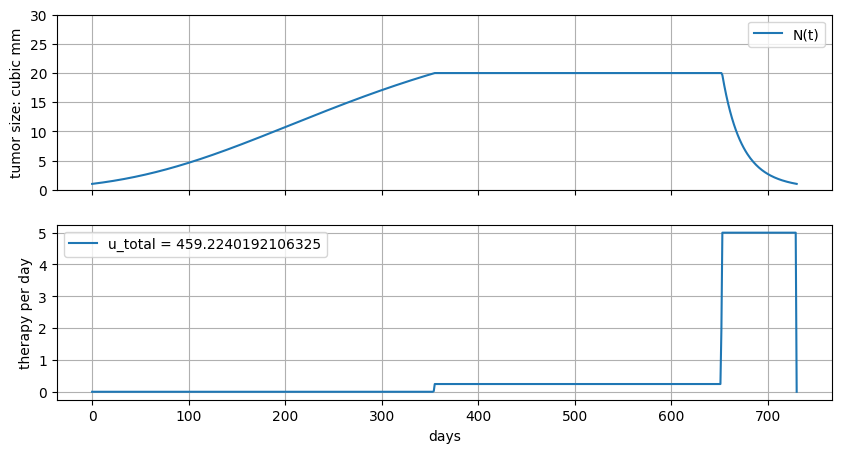

In [12]:
bN_ub = 20
u_ub = 5

def gompertz(ax):

    # build model
    m = pyo.ConcreteModel()

    # dependent variables -> t
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # indepedent variables -> N and dN/dt
    m.N = pyo.Var(m.t, bounds=(0, N_ub), initialize=N0)
    m.dN = dae.DerivativeVar(m.N, wrt=m.t)
    m.u = pyo.Var(m.t, bounds=(0, u_ub))

    # measuring total amount
    @m.Integral(m.t)
    def u_total(m, t):
        return m.u[t]

    # we need to use Pyomo's log function
    @m.Constraint(m.t)
    def ode(m, t):
        return m.dN[t] == - r * m.N[t] * pyo.log( m.N[t]/K) - alpha * m.N[t] * m.u[t]

    # initial condition
    m.N[0].fix(N0)
    m.N[tf].fix(N0)

    # objective
    @m.Objective(sense=pyo.minimize)
    def minimize_u_total(m):
        return m.u_total

    # transform and solve
    transformer.apply_to(m, wrt=m.t, nfe=730, scheme="FORWARD")
    solver.solve(m)

    # plot results
    ax[0].plot(m.t, [m.N[t].value for t in m.t], label="N(t)")
    ax[0].set_ylabel("tumor size: cubic mm")
    ax[0].set_ylim(0, K)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(m.t, [m.u[t].value for t in m.t], label=f"u_total = {m.u_total()}")
    ax[1].set_xlabel("days")
    ax[1].set_ylabel("therapy per day")
    ax[1].legend()
    ax[1].grid(True)


fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

try:
    gompertz(ax)
except:
    print("Error!!")

SyntaxError: ignored

## Radiation therapy

An unique property of radiation therapy is that effectiveness actually grows linear/quadratic function of dose rate. Here we model this as shown in the following model. 

$$\min \int_0^{t_f} u(t)\ dt$$

subject to

$$
\begin{align}
\frac{dN}{dt} & = -r N \log\left(\frac{N}{K}\right) - \alpha N(t) \left(u(t) + \gamma u(t)^2 \right) && \text{Gompertz model}\\
N(0) & = N_0 && \text{initial condition}\\
N(t_f) & = N_f && \text{final condition} \\
\end{align}
$$

Suppose we try values of $\gamma$ starting at zero and increasing. What do you expect to see?  



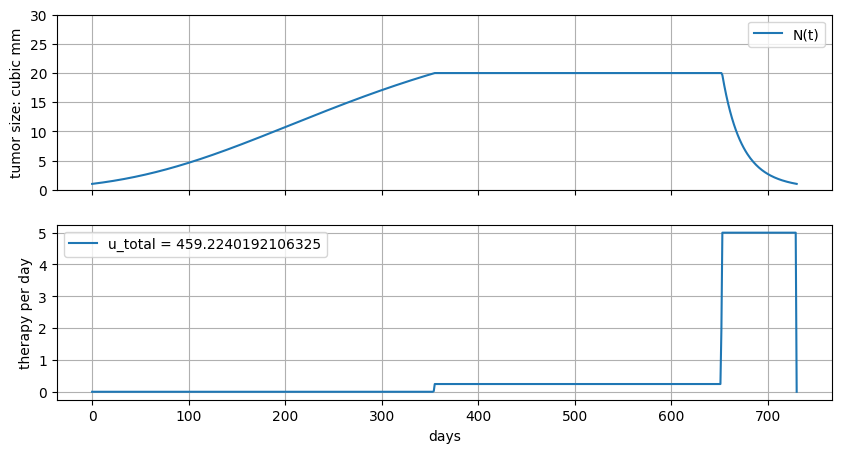

In [22]:
N_ub = 20
u_ub = 5

gamma = 0

def gompertz(ax):

    # build model
    m = pyo.ConcreteModel()

    # dependent variables -> t
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # indepedent variables -> N and dN/dt
    m.N = pyo.Var(m.t, bounds=(0, N_ub), initialize=N0)
    m.dN = dae.DerivativeVar(m.N, wrt=m.t)
    m.u = pyo.Var(m.t, bounds=(0, u_ub))

    # measuring total amount
    @m.Integral(m.t)
    def u_total(m, t):
        return m.u[t]

    # we need to use Pyomo's log function
    @m.Constraint(m.t)
    def ode(m, t):
        return m.dN[t] == - r * m.N[t] * pyo.log( m.N[t]/K) - alpha * m.N[t] * ( m.u[t] + gamma * m.u[t]**2)

    # initial condition
    m.N[0].fix(N0)
    m.N[tf].fix(N0)

    # objective
    @m.Objective(sense=pyo.minimize)
    def minimize_u_total(m):
        return m.u_total

    # transform and solve
    transformer.apply_to(m, wrt=m.t, nfe=730, scheme="FORWARD")
    solver.solve(m)

    # plot results
    ax[0].plot(m.t, [m.N[t].value for t in m.t], label="N(t)")
    ax[0].set_ylabel("tumor size: cubic mm")
    ax[0].set_ylim(0, K)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(m.t, [m.u[t].value for t in m.t], label=f"u_total = {m.u_total()}")
    ax[1].set_xlabel("days")
    ax[1].set_ylabel("therapy per day")
    ax[1].legend()
    ax[1].grid(True)


fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

try:
    gompertz(ax)
except:
    print("Error!!")

## Exercises

1. Think creatively about the objective function. From the patient's perspective, what features are missing that might improve the quality of life during the treatment period? How could you incorporate them into the mathematical model? Try one.

2. How can you create a tradeoff between long-term term objectives (i.e, keeping $N(t_f)$ as small as possible) versus shorter term objectives?

3. Suppose you believe the model and formulation, but are not sure if the parameters are right, or perhaps there are other factors that might disrupt therapy plan. How would you adapt the optimization model to stay current with the most recent data regarding the patient?